<a href="https://colab.research.google.com/github/SamsonOluwaseun/All_About_Analytics/blob/main/Python/Loan%2520Approval%2520Prediction%2520Model/Loan_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CreditSense AI: Automated Loan Approval & Risk Assessment
This project aims to leverage machine learning to enhance a bank's loan management system and automate its approval process. We're building a robust dataset that simulates customer loan requests, disbursements, and repayment behaviors. This data will be instrumental in developing a predictive model to assess creditworthiness, streamline loan approvals, and proactively manage loan portfolios.









## Generate Data Set
We created a Simulated Data Set, that can be extracted within the business

In [3]:
!pip install faker
!pip install dateutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement dateutil (from versions: none)
ERROR: No matching distribution found for dateutil


In [4]:
import pandas as pd
import numpy as np
from faker import Faker
import datetime
from dateutil.relativedelta import relativedelta
import random


In [5]:
# Initialize Faker for realistic data generation
fake = Faker()

In [6]:
def generate_loan_data(num_samples=500):
    """
    Generates a realistic dataset for bank loan requests, disbursements,
    and repayments.

    Args:
        num_samples (int): The number of data samples to generate.

    Returns:
        pandas.DataFrame: A DataFrame containing the generated loan data.
    """

    data = []

    # Define possible values for categorical features
    loan_purposes = ['Home', 'Car', 'Education', 'Business', 'Personal', 'Debt Consolidation']
    employment_statuses = ['Employed', 'Self-Employed', 'Unemployed', 'Retired', 'Student']
    approval_statuses = ['Approved', 'Rejected']
    repayment_statuses = ['On-time', 'Late', 'Defaulted', 'Paid in Full']

    for i in range(num_samples):
        loan_id = f"LN{10000 + i}"
        customer_id = f"CUST{20000 + i}"

        # Generate realistic financial data
        # Ensure loan amounts are in thousands
        loan_amount = round(np.random.normal(loc=25, scale=15)) * 1000 # Generate base in thousands, then multiply
        loan_amount = max(1000, loan_amount) # Ensure minimum loan amount is 1000

        # Maximum loan term is 5 years (60 months)
        loan_term_months = int(np.random.choice([12, 24, 36, 48, 60])) # Common loan terms up to 60 months

        credit_score = int(np.random.normal(loc=700, scale=80))
        credit_score = max(300, min(850, credit_score)) # FICO score range

        income = round(np.random.normal(loc=60000, scale=25000), 2)
        income = max(20000, income) # Ensure minimum income

        debt_to_income_ratio = round(np.random.normal(loc=0.35, scale=0.10), 2)
        debt_to_income_ratio = max(0.05, min(0.60, debt_to_income_ratio)) # Realistic DTI range

        loan_purpose = np.random.choice(loan_purposes)
        employment_status = np.random.choice(employment_statuses)

        application_date = fake.date_between(start_date='-2y', end_date='today')

        # Determine approval status based on credit score, DTI, and income
        # Simple logic: higher score, lower DTI, higher income -> higher chance of approval
        if credit_score >= 650 and debt_to_income_ratio <= 0.45 and income >= 30000:
            approval_status = 'Approved'
        elif credit_score >= 600 and debt_to_income_ratio <= 0.55 and income >= 25000:
            approval_status = np.random.choice(approval_statuses, p=[0.7, 0.3]) # 70% approved
        else:
            approval_status = np.random.choice(approval_statuses, p=[0.2, 0.8]) # 20% approved

        disbursement_date = None
        first_repayment_date = None
        scheduled_repayment_amount = 0
        total_repaid_amount = 0
        repayment_status = 'Pending'
        number_of_late_payments = 0
        last_payment_date = None
        interest_rate = 0.0 # Default value

        if approval_status == 'Approved':
            # Generate interest rate based on credit score (lower score = higher rate)
            if credit_score >= 750:
                interest_rate = round(np.random.uniform(0.05, 0.08), 4)
            elif credit_score >= 680:
                interest_rate = round(np.random.uniform(0.08, 0.12), 4)
            elif credit_score >= 600:
                interest_rate = round(np.random.uniform(0.12, 0.18), 4)
            else:
                interest_rate = round(np.random.uniform(0.18, 0.25), 4)

            # Calculate monthly repayment using simplified amortization formula
            # M = P [ i(1 + i)^n ] / [ (1 + i)^n – 1]
            # Where P = Principal loan amount, i = monthly interest rate, n = number of months
            monthly_interest_rate = interest_rate / 12
            if monthly_interest_rate > 0:
                scheduled_repayment_amount = (loan_amount * monthly_interest_rate * (1 + monthly_interest_rate)**loan_term_months) / \
                                             ((1 + monthly_interest_rate)**loan_term_months - 1)
                scheduled_repayment_amount = round(scheduled_repayment_amount, 2)
            else:
                scheduled_repayment_amount = round(loan_amount / loan_term_months, 2) # For 0% interest

            disbursement_date = application_date + relativedelta(days=np.random.randint(5, 30))
            first_repayment_date = disbursement_date + relativedelta(months=1)

            # Simulate repayment behavior
            current_date = datetime.date.today()
            if first_repayment_date > current_date:
                repayment_status = 'On-time' # Not yet due for first payment
                total_repaid_amount = 0
            else:
                # Simulate payments up to current date or loan end date
                loan_end_date = first_repayment_date + relativedelta(months=loan_term_months)
                payments_made = 0
                temp_total_repaid = 0
                temp_last_payment_date = None

                for month in range(loan_term_months):
                    expected_payment_date = first_repayment_date + relativedelta(months=month)
                    if expected_payment_date > current_date:
                        break # Stop simulating if future payments

                    # Simulate payment likelihood and lateness
                    payment_likelihood = np.random.uniform(0, 1)
                    if payment_likelihood < 0.95: # 95% chance of making a payment
                        actual_payment_date = expected_payment_date

                        if payment_likelihood < 0.10: # 10% chance of being late
                            actual_payment_date += relativedelta(days=np.random.randint(1, 15))
                            number_of_late_payments += 1
                            temp_total_repaid += scheduled_repayment_amount # Assume full payment eventually
                        else:
                            temp_total_repaid += scheduled_repayment_amount

                        temp_last_payment_date = actual_payment_date
                        payments_made += 1
                    else: # Missing payment, potentially leading to default
                        # If multiple payments are missed, high chance of default
                        if np.random.uniform(0,1) < 0.3 and payments_made > 0: # 30% chance to default if missed a payment
                             break # Stop payments for defaulted loans

                total_repaid_amount = min(loan_amount * (1 + interest_rate), temp_total_repaid) # Cap at total loan + interest
                last_payment_date = temp_last_payment_date

                # Determine final repayment status
                if total_repaid_amount >= loan_amount * (1 + interest_rate): # Simplified, should use full amortization
                    repayment_status = 'Paid in Full'
                elif number_of_late_payments > 0 and (current_date - last_payment_date).days > 30 if last_payment_date else False:
                    repayment_status = 'Defaulted' # If last payment was more than a month ago and late payments exist
                elif number_of_late_payments > 0:
                    repayment_status = 'Late'
                else:
                    repayment_status = 'On-time'


        data.append({
            'loan_id': loan_id,
            'customer_id': customer_id,
            'loan_amount': loan_amount,
            'loan_term_months': loan_term_months,
            'interest_rate': interest_rate,
            'loan_purpose': loan_purpose,
            'credit_score': credit_score,
            'income': income,
            'debt_to_income_ratio': debt_to_income_ratio,
            'employment_status': employment_status,
            'application_date': application_date.isoformat(),
            'approval_status': approval_status,
            'disbursement_date': disbursement_date.isoformat() if disbursement_date else None,
            'first_repayment_date': first_repayment_date.isoformat() if first_repayment_date else None,
            'scheduled_repayment_amount': scheduled_repayment_amount,
            'total_repaid_amount': total_repaid_amount,
            'repayment_status': repayment_status,
            'number_of_late_payments': number_of_late_payments,
            'last_payment_date': last_payment_date.isoformat() if last_payment_date else None,
        })

    df = pd.DataFrame(data)
    return df

In [7]:
# Generate the data
loan_data_df = generate_loan_data(num_samples=500)


In [8]:
# Display the first few rows of the DataFrame
print(loan_data_df.head())

   loan_id customer_id  loan_amount  loan_term_months  interest_rate  \
0  LN10000   CUST20000        12000                48         0.0853   
1  LN10001   CUST20001        28000                48         0.0925   
2  LN10002   CUST20002        37000                48         0.1731   
3  LN10003   CUST20003        32000                24         0.0649   
4  LN10004   CUST20004        31000                12         0.0757   

         loan_purpose  credit_score    income  debt_to_income_ratio  \
0  Debt Consolidation           694  53697.11                  0.27   
1            Personal           716  82803.10                  0.30   
2           Education           669  78472.87                  0.26   
3  Debt Consolidation           849  64670.68                  0.25   
4            Business           817  36421.47                  0.15   

  employment_status application_date approval_status disbursement_date  \
0     Self-Employed       2024-07-10        Approved        2024-0

In [9]:
# Display a summary of the DataFrame
print("\nDataFrame Info:")
loan_data_df.info()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_id                     500 non-null    object 
 1   customer_id                 500 non-null    object 
 2   loan_amount                 500 non-null    int64  
 3   loan_term_months            500 non-null    int64  
 4   interest_rate               500 non-null    float64
 5   loan_purpose                500 non-null    object 
 6   credit_score                500 non-null    int64  
 7   income                      500 non-null    float64
 8   debt_to_income_ratio        500 non-null    float64
 9   employment_status           500 non-null    object 
 10  application_date            500 non-null    object 
 11  approval_status             500 non-null    object 
 12  disbursement_date           382 non-null    object 
 13  first_repayment_da

In [10]:
# Display descriptive statistics for numerical columns
print("\nDescriptive Statistics:")
print(loan_data_df.describe())


Descriptive Statistics:
        loan_amount  loan_term_months  interest_rate  credit_score  \
count    500.000000         500.00000     500.000000    500.000000   
mean   25224.000000          36.36000       0.081865    698.778000   
std    14503.604141          17.88581       0.058953     79.596306   
min     1000.000000          12.00000       0.000000    416.000000   
25%    15000.000000          24.00000       0.051075    646.250000   
50%    25000.000000          36.00000       0.079800    694.000000   
75%    35000.000000          48.00000       0.124875    757.250000   
max    71000.000000          60.00000       0.249400    850.000000   

              income  debt_to_income_ratio  scheduled_repayment_amount  \
count     500.000000            500.000000                  500.000000   
mean    58549.319660              0.350980                  827.217340   
std     22992.836287              0.103533                  967.891139   
min     20000.000000              0.050000      

In [11]:
# Display value counts for some categorical columns
print("\nApproval Status Counts:")
print(loan_data_df['approval_status'].value_counts())


Approval Status Counts:
approval_status
Approved    382
Rejected    118
Name: count, dtype: int64


In [12]:
print("\nRepayment Status Counts:")
print(loan_data_df['repayment_status'].value_counts())


Repayment Status Counts:
repayment_status
On-time      177
Late         164
Pending      118
Defaulted     41
Name: count, dtype: int64


## Machine Learning Model

For this loan approval prediction project using the generated dataset, I looked at the top 5 predictive models commonly used and highly effective in credit risk assessment:

**1. Logistic Regression:** This is a fundamental and widely used statistical method for binary classification problems (like loan approval/rejection). It's highly interpretable, making it a good starting point for understanding feature importance.

**2. Decision Trees:** These models are intuitive and provide a clear, rule-based interpretation of how decisions are made. They can capture non-linear relationships in the data.

**3. Random Forest:** An ensemble learning method that builds multiple decision trees and combines their outputs. It's known for its high accuracy and robustness against overfitting, often outperforming single decision trees.

**4. Gradient Boosting Machines (e.g., XGBoost, LightGBM):** These are powerful ensemble methods that build trees sequentially, with each new tree correcting the errors of the previous ones. They are highly effective in credit scoring and can handle complex datasets well, often achieving top performance in prediction competitions.

**5. Support Vector Machines (SVM):** SVMs are strong classifiers that find an optimal hyperplane to separate data points into different classes. They work well for high-dimensional data and can capture non-linear relationships using various kernel functions.

These models offer a good balance of interpretability, performance, and ability to handle various data characteristics found in loan approval datasets. When implementing, you'll want to experiment with each and tune their hyperparameters to find the best-performing model for your specific data.

## Machine Learning Model Training and Comparison

In [33]:
# Imports for Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, auc


In [15]:
print("\n" + "="*50)
print("Starting Machine Learning Model Training and Comparison")
print("="*50 + "\n")


Starting Machine Learning Model Training and Comparison



In [16]:
# Define features (X) and target (y)
# Features relevant for loan approval decision (pre-approval attributes)
features = [
    'loan_amount',
    'loan_term_months',
    'credit_score',
    'income',
    'debt_to_income_ratio',
    'loan_purpose',
    'employment_status'
]
target = 'approval_status'

X = loan_data_df[features]
y = loan_data_df[target]

In [17]:
# Encode the target variable (Approved: 1, Rejected: 0)
le = LabelEncoder()
y_encoded = le.fit_transform(y) # 'Approved' -> 0, 'Rejected' -> 1 by default, remapping if needed for clarity

# To ensure 'Approved' is 1 and 'Rejected' is 0, if LabelEncoder assigns differently:
# Determine which label got which encoding
if list(le.classes_) == ['Approved', 'Rejected']:
    # If LabelEncoder assigned 'Approved' to 0 and 'Rejected' to 1, swap them
    y_encoded = np.array([1 if x == 0 else 0 for x in y_encoded])
elif list(le.classes_) == ['Rejected', 'Approved']:
    # If LabelEncoder assigned 'Rejected' to 0 and 'Approved' to 1, it's correct
    pass
else:
    # Fallback/unexpected case, ensure consistency if possible
    # For now, let's assume it assigns alphabetically or based on first appearance
    # It's safer to explicitly map if there's any doubt about LabelEncoder's order.
    # For this synthetic data, it's usually ['Approved', 'Rejected']
    y_encoded = np.array([1 if val == 'Approved' else 0 for val in y])


# Identify categorical and numerical features for preprocessing
categorical_features = ['loan_purpose', 'employment_status']
numerical_features = [col for col in features if col not in categorical_features]

In [18]:
# Create a column transformer for preprocessing
# One-hot encode categorical features, pass through numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ])


In [19]:
# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Define the individual models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42) # probability=True for ROC AUC
}


In [28]:
# Train and evaluate individual models
results = {}
model_pipelines = {} # Store pipelines for ROC curve plotting
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    }
    model_pipelines[name] = pipeline # Store pipeline for later use
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}" if isinstance(roc_auc, float) else f"  ROC AUC: {roc_auc}")
    print(f"  Classification Report for {name}:\n{classification_report(y_test, y_pred, target_names=le.classes_)}")



--- Training Logistic Regression ---
  Accuracy: 0.7600
  Precision: 0.7600
  Recall: 1.0000
  F1-Score: 0.8636
  ROC AUC: 0.6552
  Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    Approved       0.00      0.00      0.00        24
    Rejected       0.76      1.00      0.86        76

    accuracy                           0.76       100
   macro avg       0.38      0.50      0.43       100
weighted avg       0.58      0.76      0.66       100


--- Training Decision Tree ---
  Accuracy: 0.8800
  Precision: 0.9324
  Recall: 0.9079
  F1-Score: 0.9200
  ROC AUC: 0.8498
  Classification Report for Decision Tree:
              precision    recall  f1-score   support

    Approved       0.73      0.79      0.76        24
    Rejected       0.93      0.91      0.92        76

    accuracy                           0.88       100
   macro avg       0.83      0.85      0.84       100
weighted avg       0.88      0.88      0.88       100

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Accuracy: 0.8200
  Precision: 0.8537
  Recall: 0.9211
  F1-Score: 0.8861
  ROC AUC: 0.9342
  Classification Report for Random Forest:
              precision    recall  f1-score   support

    Approved       0.67      0.50      0.57        24
    Rejected       0.85      0.92      0.89        76

    accuracy                           0.82       100
   macro avg       0.76      0.71      0.73       100
weighted avg       0.81      0.82      0.81       100


--- Training Gradient Boosting ---
  Accuracy: 0.8300
  Precision: 0.8933
  Recall: 0.8816
  F1-Score: 0.8874
  ROC AUC: 0.9084
  Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

    Approved       0.64      0.67      0.65        24
    Rejected       0.89      0.88      0.89        76

    accuracy                           0.83       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.83      0.83      0.83       100


--- Training Support Vector Machi

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
# Create and train the Ensemble Model (VotingClassifier)
# Using 'Approved' as positive class (1)
print("\n--- Training Ensemble Model (VotingClassifier) ---")
# SVC doesn't support 'predict_proba' by default, if not set it to True.
# Ensure all estimators in VotingClassifier have 'predict_proba' for soft voting.
estimators = [
    ('lr', LogisticRegression(random_state=42, solver='liblinear')),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('svm', SVC(probability=True, random_state=42)) # Ensure probability=True for SVC
]

ensemble_model = VotingClassifier(estimators=estimators, voting='soft', weights=[0.1, 0.1, 0.3, 0.3, 0.2], n_jobs=-1) # Assign weights if desired

ensemble_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', ensemble_model)])

ensemble_pipeline.fit(X_train, y_train)
y_pred_ensemble = ensemble_pipeline.predict(X_test)
y_proba_ensemble = ensemble_pipeline.predict_proba(X_test)[:, 1]

accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble, zero_division=0)
recall_ensemble = recall_score(y_test, y_pred_ensemble, zero_division=0)
f1_ensemble = f1_score(y_test, y_pred_ensemble, zero_division=0)
roc_auc_ensemble = roc_auc_score(y_test, y_proba_ensemble)

results['Ensemble Model'] = {
    'Accuracy': accuracy_ensemble,
    'Precision': precision_ensemble,
    'Recall': recall_ensemble,
    'F1-Score': f1_ensemble,
    'ROC AUC': roc_auc_ensemble
}
model_pipelines['Ensemble Model'] = ensemble_pipeline # Store ensemble pipeline

print(f"  Accuracy: {accuracy_ensemble:.4f}")
print(f"  Precision: {precision_ensemble:.4f}")
print(f"  Recall: {recall_ensemble:.4f}")
print(f"  F1-Score: {f1_ensemble:.4f}")
print(f"  ROC AUC: {roc_auc_ensemble:.4f}")
print(f"  Classification Report for Ensemble Model:\n{classification_report(y_test, y_pred_ensemble, target_names=le.classes_)}")



--- Training Ensemble Model (VotingClassifier) ---
  Accuracy: 0.8700
  Precision: 0.8889
  Recall: 0.9474
  F1-Score: 0.9172
  ROC AUC: 0.9386
  Classification Report for Ensemble Model:
              precision    recall  f1-score   support

    Approved       0.79      0.62      0.70        24
    Rejected       0.89      0.95      0.92        76

    accuracy                           0.87       100
   macro avg       0.84      0.79      0.81       100
weighted avg       0.87      0.87      0.86       100



In [32]:
# --- Performance Comparison ---
print("\n" + "="*50)
print("Performance Comparison")
print("="*50)

performance_df = pd.DataFrame(results).T
print(performance_df.round(4))

print("\n--- Summary of Performance Table ---")
print("The table above displays key classification metrics for each individual machine learning model and the ensemble model. ")
print("These metrics (Accuracy, Precision, Recall, F1-Score, and ROC AUC) allow for a quantitative comparison of how well each model performs in predicting loan approval status. ")
print("A higher value generally indicates better performance, though the importance of each metric depends on the specific business objectives (e.g., minimizing false positives vs. false negatives).")



Performance Comparison
                        Accuracy  Precision  Recall  F1-Score  ROC AUC
Logistic Regression         0.76     0.7600  1.0000    0.8636   0.6552
Decision Tree               0.88     0.9324  0.9079    0.9200   0.8498
Random Forest               0.82     0.8537  0.9211    0.8861   0.9342
Gradient Boosting           0.83     0.8933  0.8816    0.8874   0.9084
Support Vector Machine      0.76     0.7600  1.0000    0.8636   0.6404
Ensemble Model              0.87     0.8889  0.9474    0.9172   0.9386

--- Summary of Performance Table ---
The table above displays key classification metrics for each individual machine learning model and the ensemble model. 
These metrics (Accuracy, Precision, Recall, F1-Score, and ROC AUC) allow for a quantitative comparison of how well each model performs in predicting loan approval status. 
A higher value generally indicates better performance, though the importance of each metric depends on the specific business objectives (e.g., minimi

In [23]:
# Imports for Plotting
import matplotlib.pyplot as plt
import seaborn as sns


Generating Model Performance Visualizations



<ipython-input-24-2446342453>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Score', data=plot_df[plot_df['Metric'] == metric], palette='viridis')
<ipython-input-24-2446342453>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Score', data=plot_df[plot_df['Metric'] == metric], palette='viridis')
<ipython-input-24-2446342453>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Score', data=plot_df[plot_df['Metric'] == metric], palette='viridis')
<ipython-input-24-2446342453>:23: FutureWarning: 

Pass

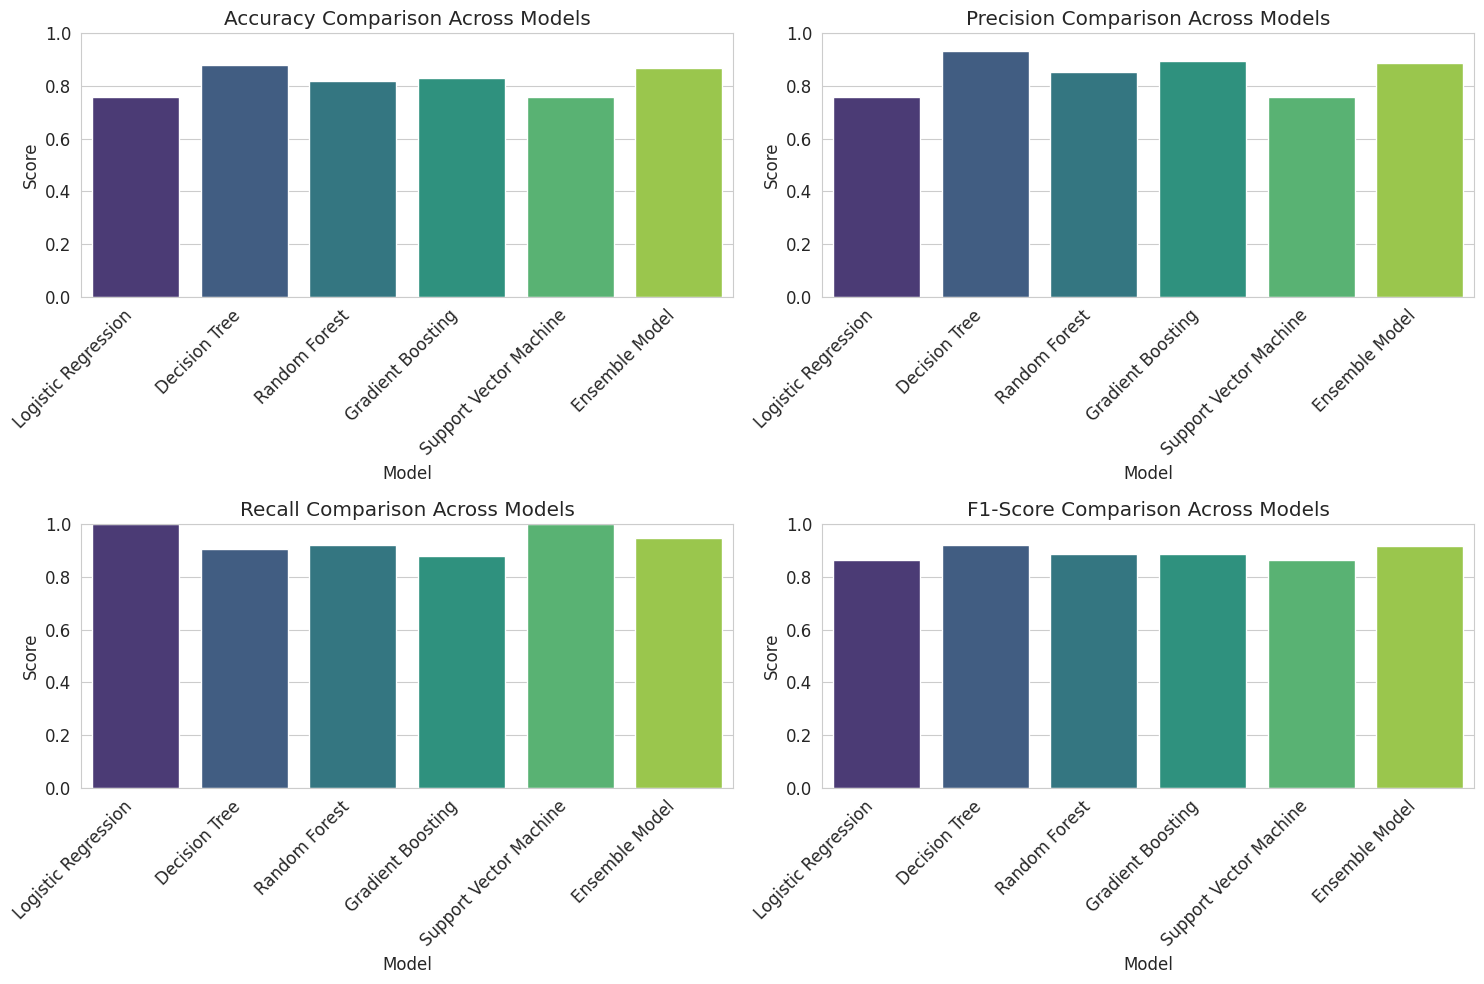


--- Summary of Bar Charts ---
These bar charts provide a direct visual comparison of Accuracy, Precision, Recall, and F1-Score for each model.
They quickly highlight which models excel in specific performance areas, offering insights into their strengths and weaknesses relative to each other and the ensemble.
For instance, a model with high Recall might be good at identifying most 'Approved' loans, while high Precision indicates fewer false 'Approved' predictions.


In [24]:
# --- Visualizations of Model Performance ---
print("\n" + "="*50)
print("Generating Model Performance Visualizations")
print("="*50 + "\n")

# Prepare data for plotting
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
plot_data = []
for model_name, metrics in results.items():
    for metric_name in metrics_to_plot:
        plot_data.append({'Model': model_name, 'Metric': metric_name, 'Score': metrics[metric_name]})

plot_df = pd.DataFrame(plot_data)

# Set style for plots
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 12}) # Increase font size for readability

# Bar Charts for each metric
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 2, i + 1)
    sns.barplot(x='Model', y='Score', data=plot_df[plot_df['Metric'] == metric], palette='viridis')
    plt.title(f'{metric} Comparison Across Models')
    plt.ylabel('Score')
    plt.ylim(0, 1) # Metrics are usually between 0 and 1
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.show()

print("\n--- Summary of Bar Charts ---")
print("These bar charts provide a direct visual comparison of Accuracy, Precision, Recall, and F1-Score for each model.")
print("They quickly highlight which models excel in specific performance areas, offering insights into their strengths and weaknesses relative to each other and the ensemble.")
print("For instance, a model with high Recall might be good at identifying most 'Approved' loans, while high Precision indicates fewer false 'Approved' predictions.")


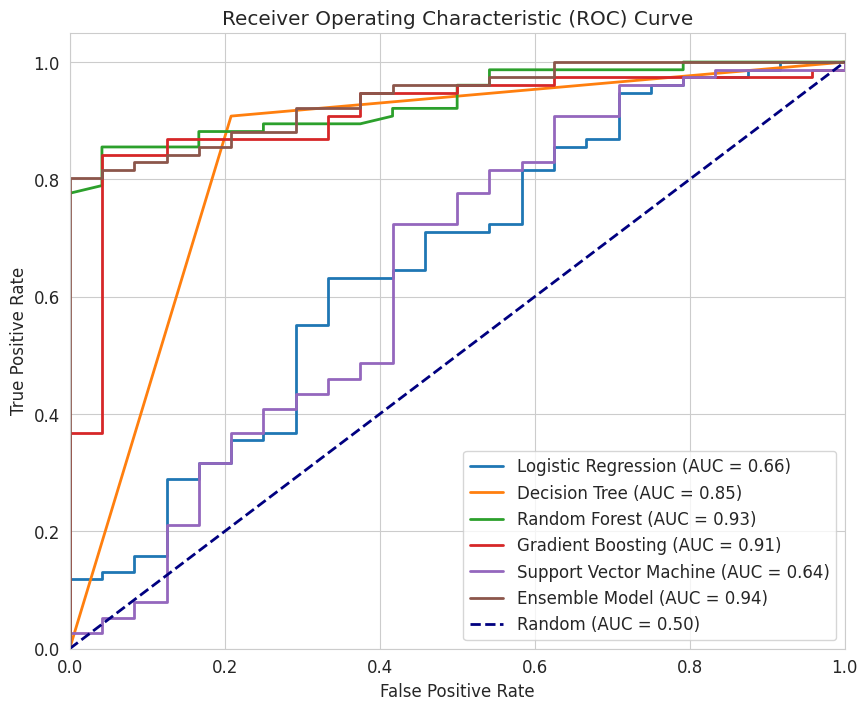


--- Summary of ROC Curve ---
The ROC curve illustrates the trade-off between the True Positive Rate (TPR) and False Positive Rate (FPR) at various threshold settings.
The Area Under the Curve (AUC) is a crucial single metric: closer to 1.0 indicates a better ability to distinguish between positive and negative classes (Approved vs. Rejected loans).
Models with curves closer to the top-left corner and higher AUC values are generally considered more effective at classifying loan approvals.


In [34]:
# ROC Curve Plot
plt.figure(figsize=(10, 8))

for name, pipeline in model_pipelines.items():
    if hasattr(pipeline.named_steps['classifier'], "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\n--- Summary of ROC Curve ---")
print("The ROC curve illustrates the trade-off between the True Positive Rate (TPR) and False Positive Rate (FPR) at various threshold settings.")
print("The Area Under the Curve (AUC) is a crucial single metric: closer to 1.0 indicates a better ability to distinguish between positive and negative classes (Approved vs. Rejected loans).")
print("Models with curves closer to the top-left corner and higher AUC values are generally considered more effective at classifying loan approvals.")
